In [3]:
#!/usr/bin/python
# encoding: utf-8

# Berreman4x4 example
# Author: O. Castany

# Example of a TiO2/SiO2 Bragg mirror with 8.5 periods

import numpy, Berreman4x4
import scipy.linalg
import matplotlib.pyplot as pyplot
from Berreman4x4 import c, pi, e_y

## Bragg example


*** SiO2/TiO2 Bragg mirror ***

Thickness of the SiO2 QWP: 263.6 nm
Thickness of the TiO2 QWP: 173.8 nm


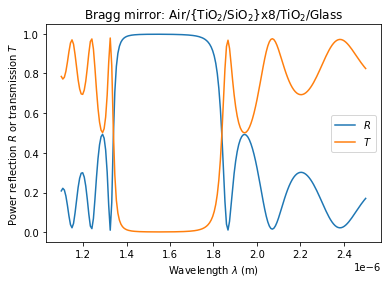

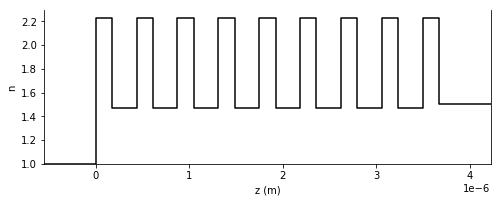

In [4]:


print("\n*** SiO2/TiO2 Bragg mirror ***\n")

# Front and back materials
air = Berreman4x4.IsotropicNonDispersiveMaterial(1.0)
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.5)

front = Berreman4x4.IsotropicHalfSpace(air)
back = Berreman4x4.IsotropicHalfSpace(glass)

# Materials for a SiO2/TiO2 Bragg mirror
lbda0 = 1.550e-6
k0 = 2*pi/lbda0
nr_SiO2 = 1.47
nr_TiO2 = 2.23
alpha_SiO2 = 0e2    # (m⁻¹)
alpha_TiO2 = 42e2   # (m⁻¹)
ni_SiO2 = alpha_SiO2 * lbda0 / (4*pi)
ni_TiO2 = alpha_TiO2 * lbda0 / (4*pi)
n_SiO2 = nr_SiO2 + 1j * ni_SiO2
n_TiO2 = nr_TiO2 + 1j * ni_TiO2

SiO2 = Berreman4x4.IsotropicNonDispersiveMaterial(n_SiO2)
TiO2 = Berreman4x4.IsotropicNonDispersiveMaterial(n_TiO2)

# Layers
L_SiO2 = Berreman4x4.HomogeneousIsotropicLayer(SiO2, ("QWP", lbda0))
L_TiO2 = Berreman4x4.HomogeneousIsotropicLayer(TiO2, ("QWP", lbda0))

print("Thickness of the SiO2 QWP: {:.1f} nm".format(L_SiO2.h*1e9))
print("Thickness of the TiO2 QWP: {:.1f} nm".format(L_TiO2.h*1e9))

# Repeated layers: 8.5 periods
L = Berreman4x4.RepeatedLayers([L_TiO2, L_SiO2], 8, 0, 1)

# To reduce the number of printed characters in the numbers:
# numpy.set_printoptions(suppress=True, precision=3)
Kx = 0.0

# Structure
s = Berreman4x4.Structure(front, [L], back)

# Calculation
(lbda1, lbda2) = (1.1e-6, 2.5e-6)
lbda_list = numpy.linspace(lbda1, lbda2, 200)

data = Berreman4x4.DataList([s.evaluate(Kx, 2*pi/lbda) for lbda in lbda_list])

R = data.get('R_ss')
T = data.get('T_ss')

# Plotting 
fig = pyplot.figure()
ax = fig.add_subplot("111")
ax.plot(lbda_list, R, label="$R$")
ax.plot(lbda_list, T, label="$T$")

ax.legend(loc='center right')
ax.set_xlabel(r"Wavelength $\lambda$ (m)")
ax.set_ylabel(r"Power reflection $R$ or transmission $T$")
ax.set_title(r"Bragg mirror: Air/{TiO$_2$/SiO$_2$}x8/TiO$_2$/Glass")

fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3,3))

s.drawStructure()
pyplot.show()



## Twisted nematic example


Consider the following situation:
- twisted liquid crystal with 90° twist between z=0 and z=d
- liquid crystal aligned along x at z=0.
- input and output polarizers aligned parallel to x

Gooch-Tarry law gives: 
$$T_pp = sin²(pi/2·√(1+u²)) / (1+u²),$$
with u = 2dΔn/λ. 
The transmission minima are given by 
$$u = ((2m)²-1)^{-1/2} = √(3),√(15),√(35),...$$

We consider a birefringence Δn = 0.10 and a thickness d = 4.33 µm. The first
minimum should be at λ = 500 nm, or k0 = 1.257e7 m⁻¹.

Note: Gooch-Tarry law does not take into account interferences between the two
glass substrates. A glass with n = 1.55 minimizes the interferences.


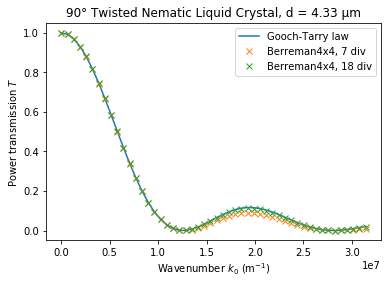

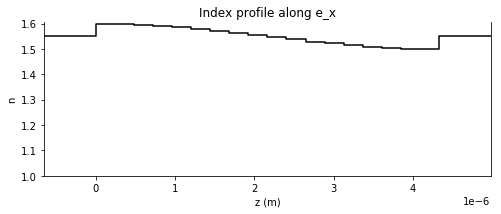

In [5]:

# Materials
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.55)
front = back = Berreman4x4.IsotropicHalfSpace(glass)

# Liquid crystal oriented along the x direction
(no, ne) = (1.5, 1.6)
Dn = ne-no
LC = Berreman4x4.UniaxialNonDispersiveMaterial(no, ne)
R = Berreman4x4.rotation_v_theta(e_y, pi/2)
LC = LC.rotated(R)
d = 4.33e-6
TN = Berreman4x4.TwistedMaterial(LC, d)

# Inhomogeneous layer
IL = Berreman4x4.InhomogeneousLayer(TN)

# Structure
s = Berreman4x4.Structure(front, [IL], back)

# Normal incidence: 
Kx = 0.0

# Calculation parameters
(lbda_min, lbda_max) = (200e-9, 1)   # (m)
k0_list = numpy.linspace(2*pi/lbda_max, 2*pi/lbda_min)

# Plot setup
fig = pyplot.figure()
ax = fig.add_subplot("111")

# Plot Gooch-Tarry law, for comparison
u = 2*d*Dn*k0_list/(2*pi)
T = numpy.sin(pi/2*numpy.sqrt(1+u**2))**2 / (1+u**2)
ax.plot(k0_list, T, label="Gooch-Tarry law")

# Calulation with Berreman4x4 and plotting
def plotTransmission(label):
    """Plots power transmission vs. wavenumber."""
    data = Berreman4x4.DataList([s.evaluate(Kx,k0) for k0 in k0_list])
    T = data.get('T_pp')
    ax.plot(k0_list, T, 'x', label=label)

# Two plots are made, with 7 or 18 divisions in the TwistedMaterial
TN.setDivision(7)
plotTransmission("Berreman4x4, 7 div")
TN.setDivision(18) 
plotTransmission("Berreman4x4, 18 div")

# Titles
ax.set_title(u"90° Twisted Nematic Liquid Crystal, " + 
             u"d = {:.2f} µm".format(d*1e6))
ax.set_xlabel(r"Wavenumber $k_0$ (m$^{-1}$)")
ax.set_ylabel(r"Power transmission $T$")
ax.legend()

ax = s.drawStructure()
ax.set_title("Index profile along e_x")
pyplot.show()



## Example of a cholesteric liquid crystal

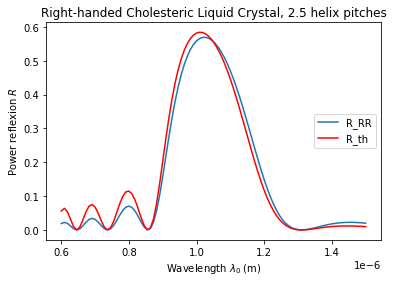

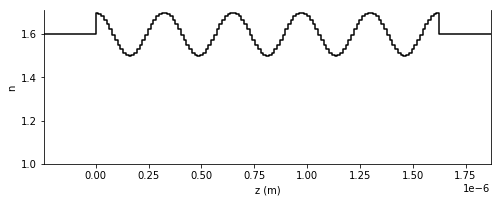

In [6]:
#!/usr/bin/python
# encoding: utf-8

# Berreman4x4 example
# Author: O. Castany, C. Molinaro

# Example of a cholesteric liquid crystal 

############################################################################
# Structure

# Materials
glass = Berreman4x4.IsotropicNonDispersiveMaterial(1.6)
front = back = Berreman4x4.IsotropicHalfSpace(glass)

# Liquid crystal oriented along the x direction
(no, ne) = (1.5, 1.7)
Dn = ne-no
n_med = (ne + no)/2
LC = Berreman4x4.UniaxialNonDispersiveMaterial(no, ne)  # ne along z
R = Berreman4x4.rotation_v_theta(e_y, pi/2)         # rotation round y
LC = LC.rotated(R)              # apply rotation from z to x
# Cholesteric pitch:
p = 0.65e-6
# One half turn of a right-handed helix:
TN = Berreman4x4.TwistedMaterial(LC, p/2, angle=+pi, div=25)

# Inhomogeneous layer, repeated layer, and structure
IL = Berreman4x4.InhomogeneousLayer(TN)
N = 5 # number half pitch repetitions
h = N * p/2
L = Berreman4x4.RepeatedLayers([IL], N)
s = Berreman4x4.Structure(front, [L], back)

# Normal incidence: 
Kx = 0.0

# Calculation parameters
lbda_min, lbda_max = 0.6e-6, 1.5e-6   # (m)
lbda = numpy.linspace(lbda_min, lbda_max, 100)
k0 = 2*pi/lbda

############################################################################
# Analytical calculation for the power reflection coefficient
q = 2*pi/p
alpha = q/k0
epsilon = (no**2+ne**2)/2
delta = (no**2-ne**2)/2
n2 = numpy.sqrt((alpha**2 + epsilon \
     - numpy.sqrt(4*epsilon*alpha**2+delta**2)).astype(complex))
w = 1j*(ne**2-n2**2-alpha**2)/(2*alpha*n2) # not k0/c 
A = -2j*k0*n2*h

R_th = abs((w**2+1)*(1-numpy.exp(-2j*k0*n2*h)) \
           / (2*w*(1+numpy.exp(-2j*k0*n2*h)) \
           - 1j*(w**2-1)*(1-numpy.exp(-2j*k0*n2*h))))**2

############################################################################
# Calculation with Berreman4x4
data = Berreman4x4.DataList([s.evaluate(Kx,_k0) for _k0 in k0])

# Jones matrices for the circular wave basis
# Right-circular wave is reflected in the stop-band
# R_LR, T_LR close to zero
R_RR = data.get('R_RR')

############################################################################
# Plotting
fig = pyplot.figure()
ax = fig.add_subplot("111")

ax.plot(lbda, R_RR, label='R_RR')
ax.plot(lbda, R_th, 'r', label='R_th')

ax.legend(loc='center right', bbox_to_anchor=(1.00, 0.50))

ax.set_title("Right-handed Cholesteric Liquid Crystal, " +
             "{:.1f} helix pitches".format(N/2.))
ax.set_xlabel(r"Wavelength $\lambda_0$ (m)")
ax.set_ylabel(r"Power reflexion $R$")
fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3,3))

s.drawStructure()
pyplot.show()